In [1]:
import numpy as np
import pandas as pd
from random import choice
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import neattext.functions as ntf
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud 

import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')

In [2]:
df_cleaned = pd.read_csv("Data/cleaded_data.csv")
df_cleaned.head()

,date,username,like_count,retweet_count,processed_content
0,2023-03-29,RealProfitPros,0.0,0.0,"free ai marketing automation tools, strategies..."
1,2023-03-29,AmyLouWho321,0.0,0.0,chat gpt says 15. :face_with_tears_of_joy:
2,2023-03-29,yjleon1976,0.0,0.0,- chat pdf! check new ai quickly answers quest...
3,2023-03-29,ChatGPT_Thinks,0.0,0.0,"ai muses: ""in court life, face judge destiny j..."
4,2023-03-29,cordydbarb,0.0,0.0,no! chat gpt putting amazing recipes :tired_fa...


### WordCloud

In [3]:
## Lemmatize processed text 
wordnet_lem = WordNetLemmatizer()

df_cleaned['content_lem'] = df_cleaned['processed_content'].apply(wordnet_lem.lemmatize).apply(ntf.remove_puncts).apply(ntf.remove_shortwords)
all_words_lem = ' '.join([word for word in df_cleaned['content_lem']])

In [4]:
## Define a custom color function for Wordcloud
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7', '#800000', '#9370DB',
             '#7CFC00', '#1E90FF', '#FF3030', '#FFD700']
    return choice(colors)

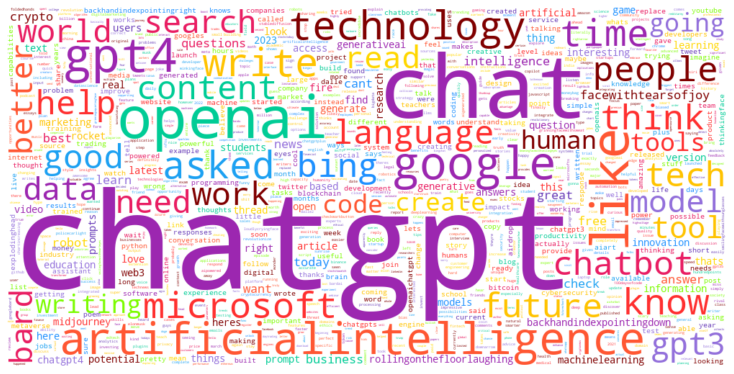

In [5]:
## create a word cloud
word_frequencies = dict(Counter(all_words_lem.split(' ')).most_common())

wordcloud_twitter = WordCloud(height=500, width=1000, max_words=1000,
                              background_color="white", mode="RGB",
                              ).generate_from_frequencies(word_frequencies)

plt.figure(figsize=[10, 5])
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=custom_color_func), interpolation="bilinear")

# Store visualization to file
plt.savefig("twitter_unigram.png", format="png", dpi=300)

plt.show()

### LDA

In [6]:
# Let's sort the dataframe and get top 10000 most liked tweets

df_sorted = df_cleaned.sort_values(by='like_count', ascending=False)
df_top_10000 = df_sorted.iloc[:10000]

In [7]:
## lemmatize the processed content
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

docs = df_top_10000['processed_content'].apply(lambda x: [lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])

# Create a dictionary of words and their frequency
dictionary = corpora.Dictionary(docs)

# Create a document-term matrix
corpus = [dictionary.doc2bow(doc) for doc in docs]


In [8]:
## Topic modeling using LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=10, random_state=100, 
                                            chunksize=1000, passes=10, per_word_topics=True)
# topics and their top words
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {} \n'.format(idx, topic))
    

Topic: 0 
Words: 0.018*"wrong" + 0.017*"market" + 0.015*"solution" + 0.015*"na" + 0.010*"gon" + 0.010*"stock" + 0.010*"information" + 0.008*"likely" + 0.008*"engineering" + 0.007*"warning" 

Topic: 1 
Words: 0.053*"chatgpt" + 0.034*"asked" + 0.027*"write" + 0.020*"poem" + 0.009*"maybe" + 0.008*"bit" + 0.008*"analytics" + 0.008*"style" + 0.007*"sound" + 0.007*"collision" 

Topic: 2 
Words: 0.039*"chatgpt" + 0.014*"good" + 0.013*"like" + 0.011*"thing" + 0.010*"going" + 0.009*"job" + 0.008*"people" + 0.008*"asked" + 0.008*"think" + 0.008*"tell" 

Topic: 3 
Words: 0.061*"chatgpt" + 0.020*"question" + 0.017*"answer" + 0.016*"asked" + 0.014*"ai" + 0.010*"ask" + 0.007*"story" + 0.007*"said" + 0.006*"research" + 0.006*"time" 

Topic: 4 
Words: 0.051*"chatgpt" + 0.016*"prompt" + 0.010*"follow" + 0.010*"free" + 0.009*"link" + 0.009*"post" + 0.008*"comment" + 0.007*"like" + 0.007*"following" + 0.006*"hour" 

Topic: 5 
Words: 0.090*"ai" + 0.084*"chatgpt" + 0.017*"technology" + 0.013*"openai" + 0.0

#### LDA fine tunning

In [9]:
# Considering 1-15 topic
num_topics = list(range(16)[1:])
alpha_list = [0.2, 0.3, 'symmetric']

num_keywords = 15

LDA_models = {}
LDA_topics = {}

for j, alp in enumerate(alpha_list):
    if j not in LDA_models:
        LDA_models[j]={}
    if j not in LDA_topics:
        LDA_topics[j]={}
        
    for i in num_topics:
        print("Alpha value: ", alpha_list[j], "Number of Topics: ", i)
        
        LDA_models[j][i] = LdaModel(corpus=corpus, id2word=dictionary,
                                 num_topics=i, update_every=1,
                                 chunksize = 1000,
                                 passes=10, alpha= alp,
                                 random_state=42)

        shown_topics = LDA_models[j][i].show_topics(num_topics=i, 
                                                 num_words=num_keywords,
                                                 formatted=False)
        LDA_topics[j][i] = [[word[0] for word in topic[1]] for topic in shown_topics]
    
    

def jaccard_similarity(topic_1, topic_2):    
    #Derives the Jaccard similarity of two topics

    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))



Alpha value:  0.2 Number of Topics:  1
Alpha value:  0.2 Number of Topics:  2
Alpha value:  0.2 Number of Topics:  3
Alpha value:  0.2 Number of Topics:  4
Alpha value:  0.2 Number of Topics:  5
Alpha value:  0.2 Number of Topics:  6
Alpha value:  0.2 Number of Topics:  7
Alpha value:  0.2 Number of Topics:  8
Alpha value:  0.2 Number of Topics:  9
Alpha value:  0.2 Number of Topics:  10
Alpha value:  0.2 Number of Topics:  11
Alpha value:  0.2 Number of Topics:  12
Alpha value:  0.2 Number of Topics:  13
Alpha value:  0.2 Number of Topics:  14
Alpha value:  0.2 Number of Topics:  15
Alpha value:  0.3 Number of Topics:  1
Alpha value:  0.3 Number of Topics:  2
Alpha value:  0.3 Number of Topics:  3
Alpha value:  0.3 Number of Topics:  4
Alpha value:  0.3 Number of Topics:  5
Alpha value:  0.3 Number of Topics:  6
Alpha value:  0.3 Number of Topics:  7
Alpha value:  0.3 Number of Topics:  8
Alpha value:  0.3 Number of Topics:  9
Alpha value:  0.3 Number of Topics:  10
Alpha value:  0.3 

In [10]:
LDA_stability = {}
mean_stabilities = {}
coherences = {}
for j in range(len(alpha_list)):
    if j not in LDA_stability:
        LDA_stability[j]={}
    for i in range(0, len(num_topics)-1):
        jaccard_sims = []
        for t1, topic1 in enumerate(LDA_topics[j][num_topics[i]]): 
            sims = []
            for t2, topic2 in enumerate(LDA_topics[j][num_topics[i+1]]): 
                sims.append(jaccard_similarity(topic1, topic2))    

            jaccard_sims.append(sims)    
        LDA_stability[j][num_topics[i]] = jaccard_sims
                
    mean_stabilities[j] = [np.array(LDA_stability[j][i]).mean() for i in num_topics[:-1]]

    coherences[j] = [CoherenceModel(model=LDA_models[j][i], corpus=corpus,  coherence='u_mass').get_coherence()\
                  for i in num_topics[:-1]]



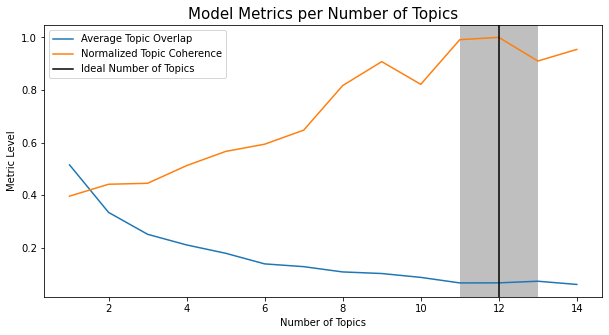

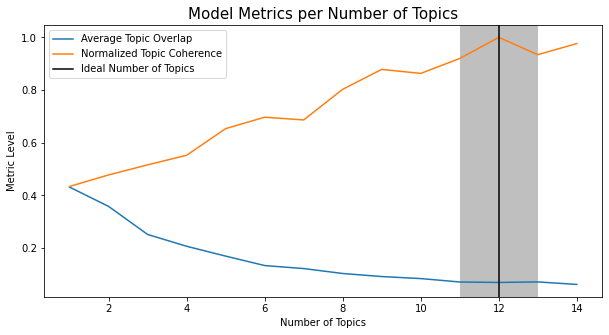

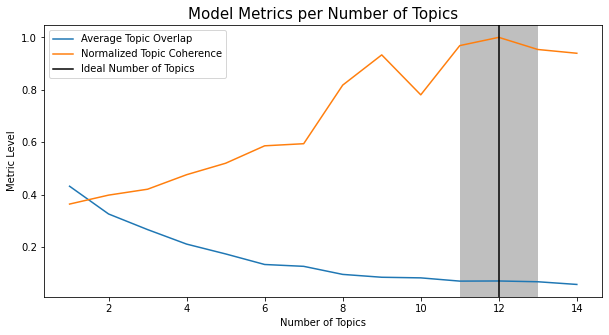

In [11]:
best_cases = {}
for j in range(len(alpha_list)):
    coh_sta_diffs = [coherences[j][i]/(min(coherences[j])) - mean_stabilities[j][i] for i in range(len(num_topics))[:-1]] 
    coh_sta_max = max(coh_sta_diffs)
    coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
    ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
    ideal_topic_num = num_topics[ideal_topic_num_index]
    best_cases[j]= (j, ideal_topic_num_index)
    
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities[j], label='Average Topic Overlap')
    ax = sns.lineplot(x=num_topics[:-1], y=coherences[j]/(min(coherences[j])), label='Normalized Topic Coherence')

    ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
    ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

    ax.axes.set_title('Model Metrics per Number of Topics', fontsize=15)
    ax.set_ylabel('Metric Level', fontsize=10)
    ax.set_xlabel('Number of Topics', fontsize=10)
    plt.legend(fontsize=10)
    plt.show()   

In [12]:
best_cases

{0: (0, 11), 1: (1, 11), 2: (2, 11)}

In [13]:
#compare
diff = []
for i, (alp, num_index) in enumerate(best_cases.values()):
    diff.append(coherences[alp][num_index]/min(coherences[alp]) - mean_stabilities[alp][num_index])
    
# most optimal LDA model is:
index_best = best_cases[diff.index(max(diff))]
print("Alpha value: ", alpha_list[index_best[0]], "Number of Topics: ", num_topics[index_best[1]])

Alpha value:  0.2 Number of Topics:  12


#### Best LDA model after optimization

In [16]:
for i, words in enumerate(LDA_topics[index_best[0]][num_topics[index_best[1]]]):
    print("Topic",i+1 , ": Top words\n",words,'\n')

Topic 1 : Top words
 ['chatgpt', 'asked', 'write', 'answer', 'question', 'ask', 'poem', 'love', 'style', 'explain', 'got', 'asking', 'gave', 'tell', 'friend'] 

Topic 2 : Top words
 ['chatgpt', 'student', 'use', 'better', 'bot', 'teacher', 'work', 'time', 'tool', 'btc', 'able', 'way', 'maybe', 'essay', 'help'] 

Topic 3 : Top words
 ['chatgpt', 'ai', 'google', 'model', 'new', 'openai', 'language', 'search', 'microsoft', 'tool', 'like', 'bing', 'chatbot', 'text', 'bard'] 

Topic 4 : Top words
 ['ai', 'chatgpt', 'technology', 'artificialintelligence', 'machinelearning', 'robot', 'tech', 'generativeai', 'python', 'openai', 'metaverse', 'innovation', 'art', 'tool', 'eye'] 

Topic 5 : Top words
 ['point', 'money', 'minute', 'skill', 'line', 'finally', 'challenge', 'productivity', 'play', 'error', 'sign', 'beginning', 'god', 'forward', 'funny'] 

Topic 6 : Top words
 ['chatgpt', 'ai', 'crypto', 'openai', 'rocket', 'token', 'know', 'blockchain', 'nft', 'launch', 'like', 'eth', 'robot', 'fire'